# Загрузка данных

Импорт и установка библиотек

In [1]:
!pip install pmdarima
!pip install numpy==1.26.0
!pip install --upgrade tensorflow


import pickle
import warnings
import requests
import statsmodels
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from io import BytesIO
from datetime import datetime
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import acf, adfuller
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error


warnings.filterwarnings("ignore")
%matplotlib inline

Выберите способ загрузки данных

In [2]:
url = "https://github.com/samoletpanfilov/reinforcement_task/raw/refs/heads/master/data/train.xlsx"  # Ссылка должна содержать raw
response = requests.get(url)
df_ts = pd.read_excel(BytesIO(response.content), engine='openpyxl')

In [3]:
# df_ts = pd.read_excel('/content/drive/MyDrive/int/train.xlsx')

# Анализ и предобработка

### просмотр статистической информации

In [4]:
df_ts.head(15)

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
5,2015-02-09,30300
6,2015-02-16,30100
7,2015-02-23,29400
8,2015-03-02,29200
9,2015-03-09,29000


In [5]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


In [6]:
# Проверка на наличие NaN
df_ts['dt'].isna().sum()

0

In [7]:
df_ts.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [8]:
df_ts.shape

(400, 2)

### Визуализация

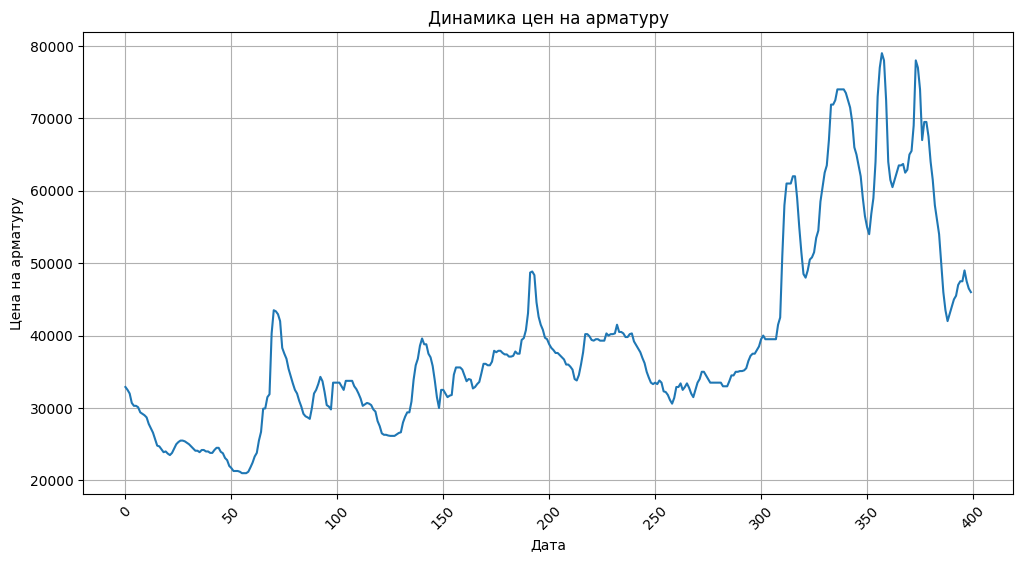

In [9]:
# Строим график
plt.figure(figsize=(12, 6))
plt.plot(df_ts["Цена на арматуру"], marker='', linestyle='-')

# Настроим оси и заголовок
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Динамика цен на арматуру")
plt.grid(True)

# Улучшим читаемость меток дат
plt.xticks(rotation=45)

# Показываем график
plt.show()

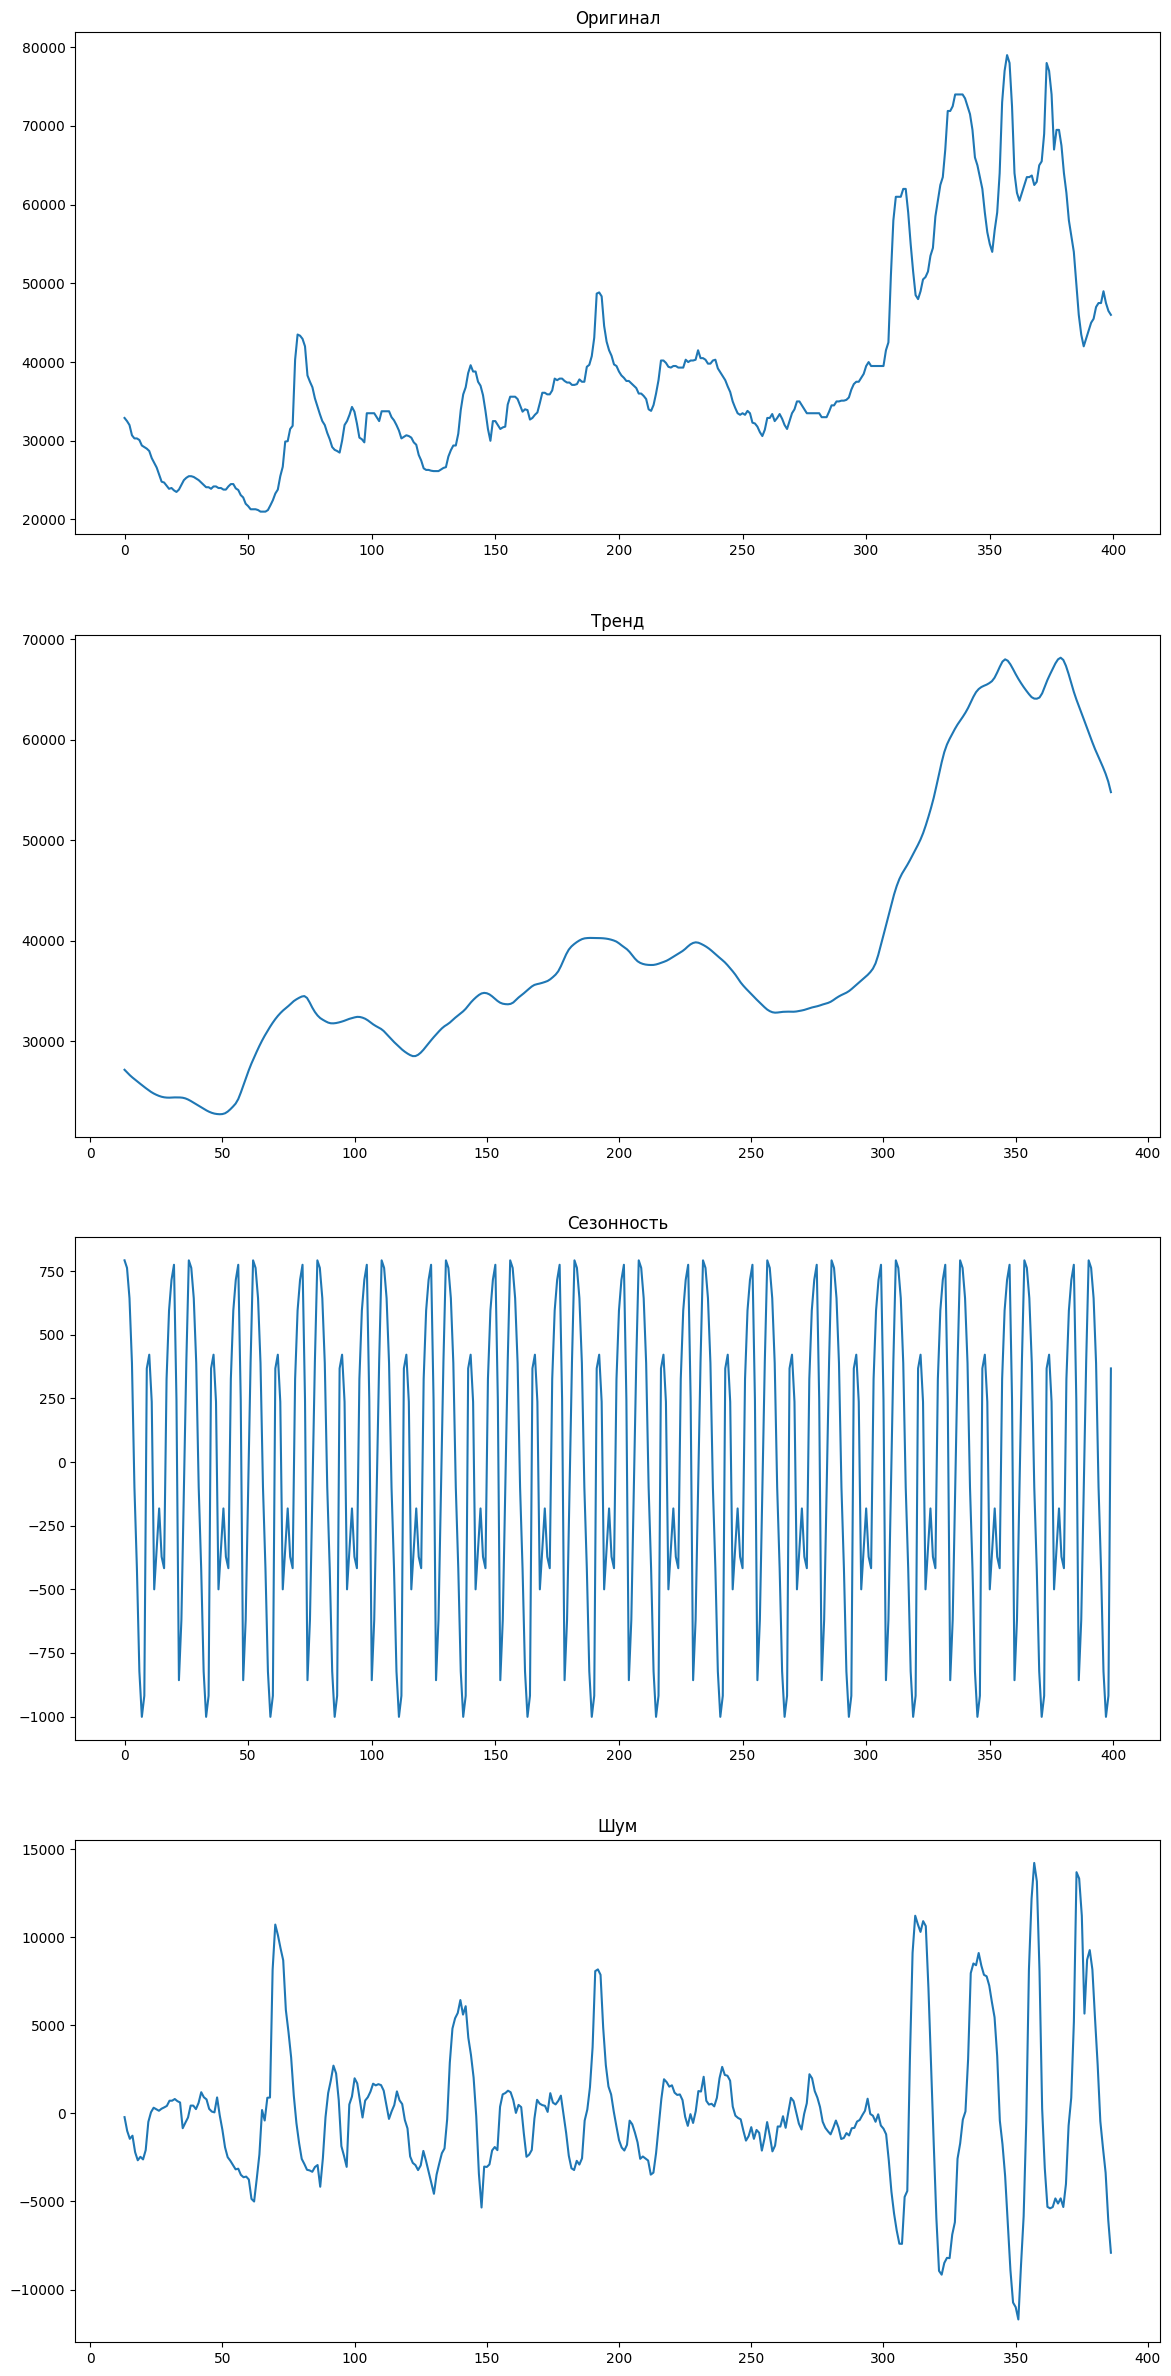

In [10]:
# Разложим ряд на компоненты и проверим ответы на вопросы

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 30))
decompose = seasonal_decompose(df_ts['Цена на арматуру'],period = 26)

ax[0].set_title('Оригинал')
ax[1].set_title('Тренд')
ax[2].set_title('Сезонность')
ax[3].set_title('Шум')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

In [11]:
# # Разложение временного ряда с экстраполяцией тренда
# decompose = seasonal_decompose(df_ts['Цена на арматуру'], period=52, extrapolate_trend='freq')

# # Визуализация
# fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 30))

# ax[0].set_title('Оригинал')
# ax[1].set_title('Тренд')
# ax[2].set_title('Сезонность')
# ax[3].set_title('Шум')

# decompose.observed.plot(ax=ax[0], legend=False)
# decompose.trend.plot(ax=ax[1], legend=False)
# decompose.seasonal.plot(ax=ax[2], legend=False)
# decompose.resid.plot(ax=ax[3], legend=False)

# plt.tight_layout()
# plt.show()

### тест вариант

In [12]:
df_ts.head()

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300


### Работа с автокорреляцией

In [13]:
# Получил 'сырые' значения автокорреляций
acf(df_ts["Цена на арматуру"] ,nlags = 100, fft = False)

array([1.        , 0.99138242, 0.97367714, 0.95122039, 0.92740427,
       0.90357365, 0.88126621, 0.8606089 , 0.84235253, 0.82671727,
       0.81349611, 0.8020525 , 0.7925797 , 0.78508849, 0.78019657,
       0.77692922, 0.77376814, 0.76901294, 0.76227632, 0.75319077,
       0.74261145, 0.7309889 , 0.71862345, 0.7046383 , 0.68939965,
       0.67325908, 0.65612584, 0.63820561, 0.62109396, 0.60459259,
       0.58872289, 0.57435372, 0.56120831, 0.54900152, 0.5377084 ,
       0.5271632 , 0.51674918, 0.5068141 , 0.49691253, 0.48636205,
       0.47460061, 0.4600824 , 0.44257206, 0.42285538, 0.40223733,
       0.38033844, 0.35769402, 0.33517203, 0.31316745, 0.29306128,
       0.27522925, 0.2595102 , 0.24447201, 0.23086215, 0.21896621,
       0.20859445, 0.1993889 , 0.19088593, 0.18300826, 0.1757314 ,
       0.16880023, 0.16166525, 0.15350675, 0.14370082, 0.13267574,
       0.12198755, 0.11231837, 0.10288107, 0.0929827 , 0.08286002,
       0.07336018, 0.06476539, 0.05709237, 0.05068118, 0.04473

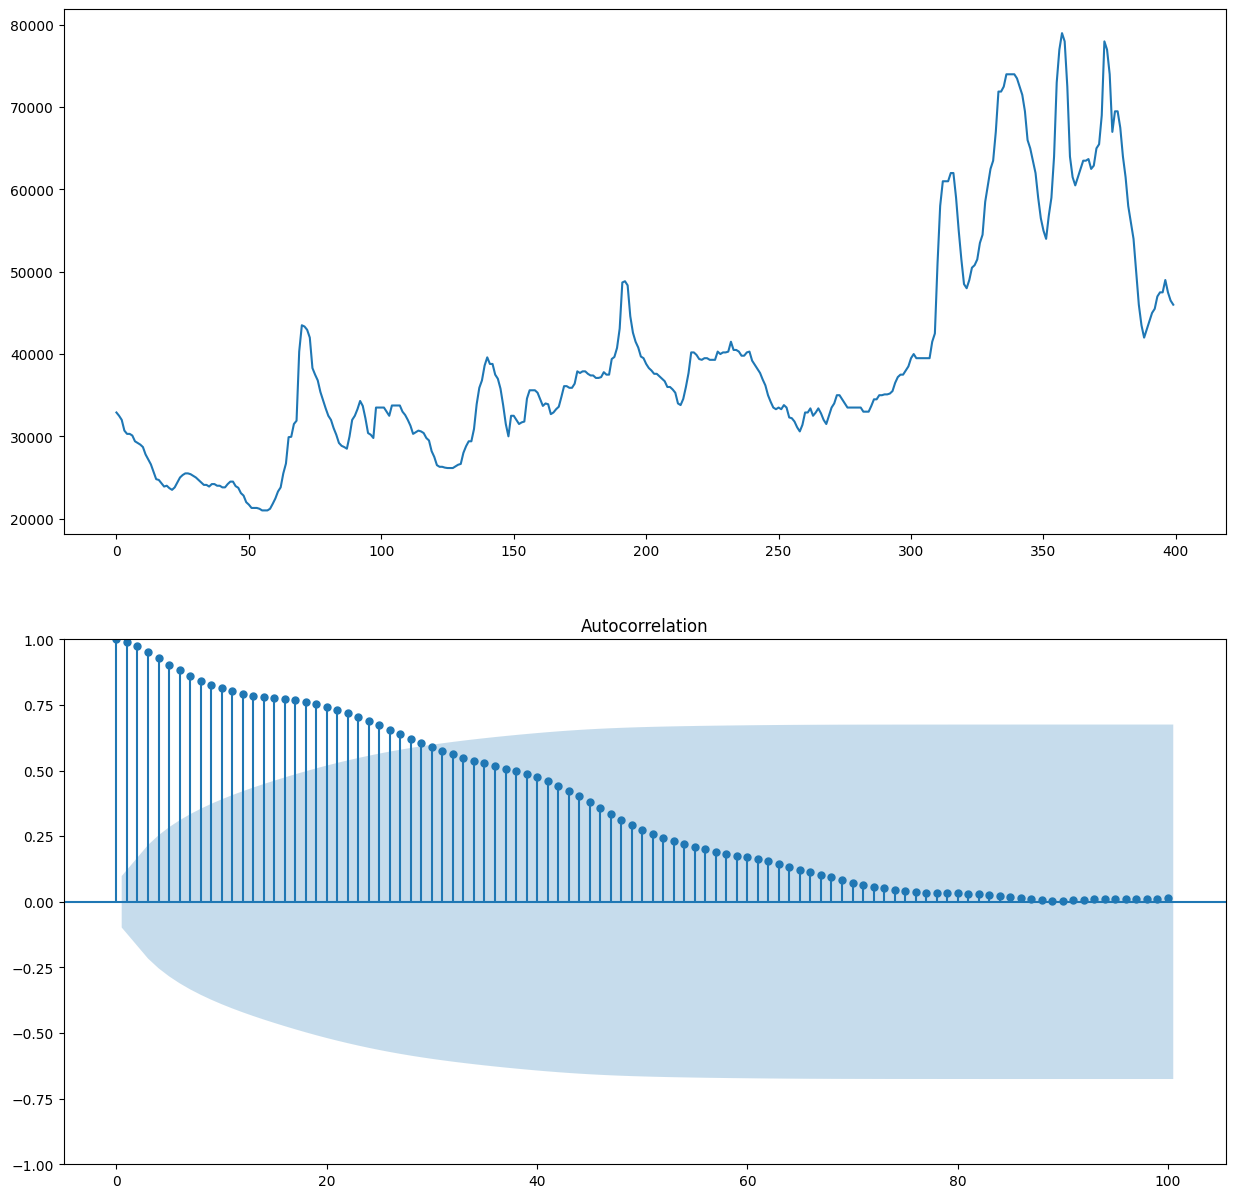

In [14]:
# Визуализация автокорреляции

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
df_ts['Цена на арматуру'].plot(ax=ax[0])
plot_acf(df_ts['Цена на арматуру'], lags=100, ax=ax[1]);

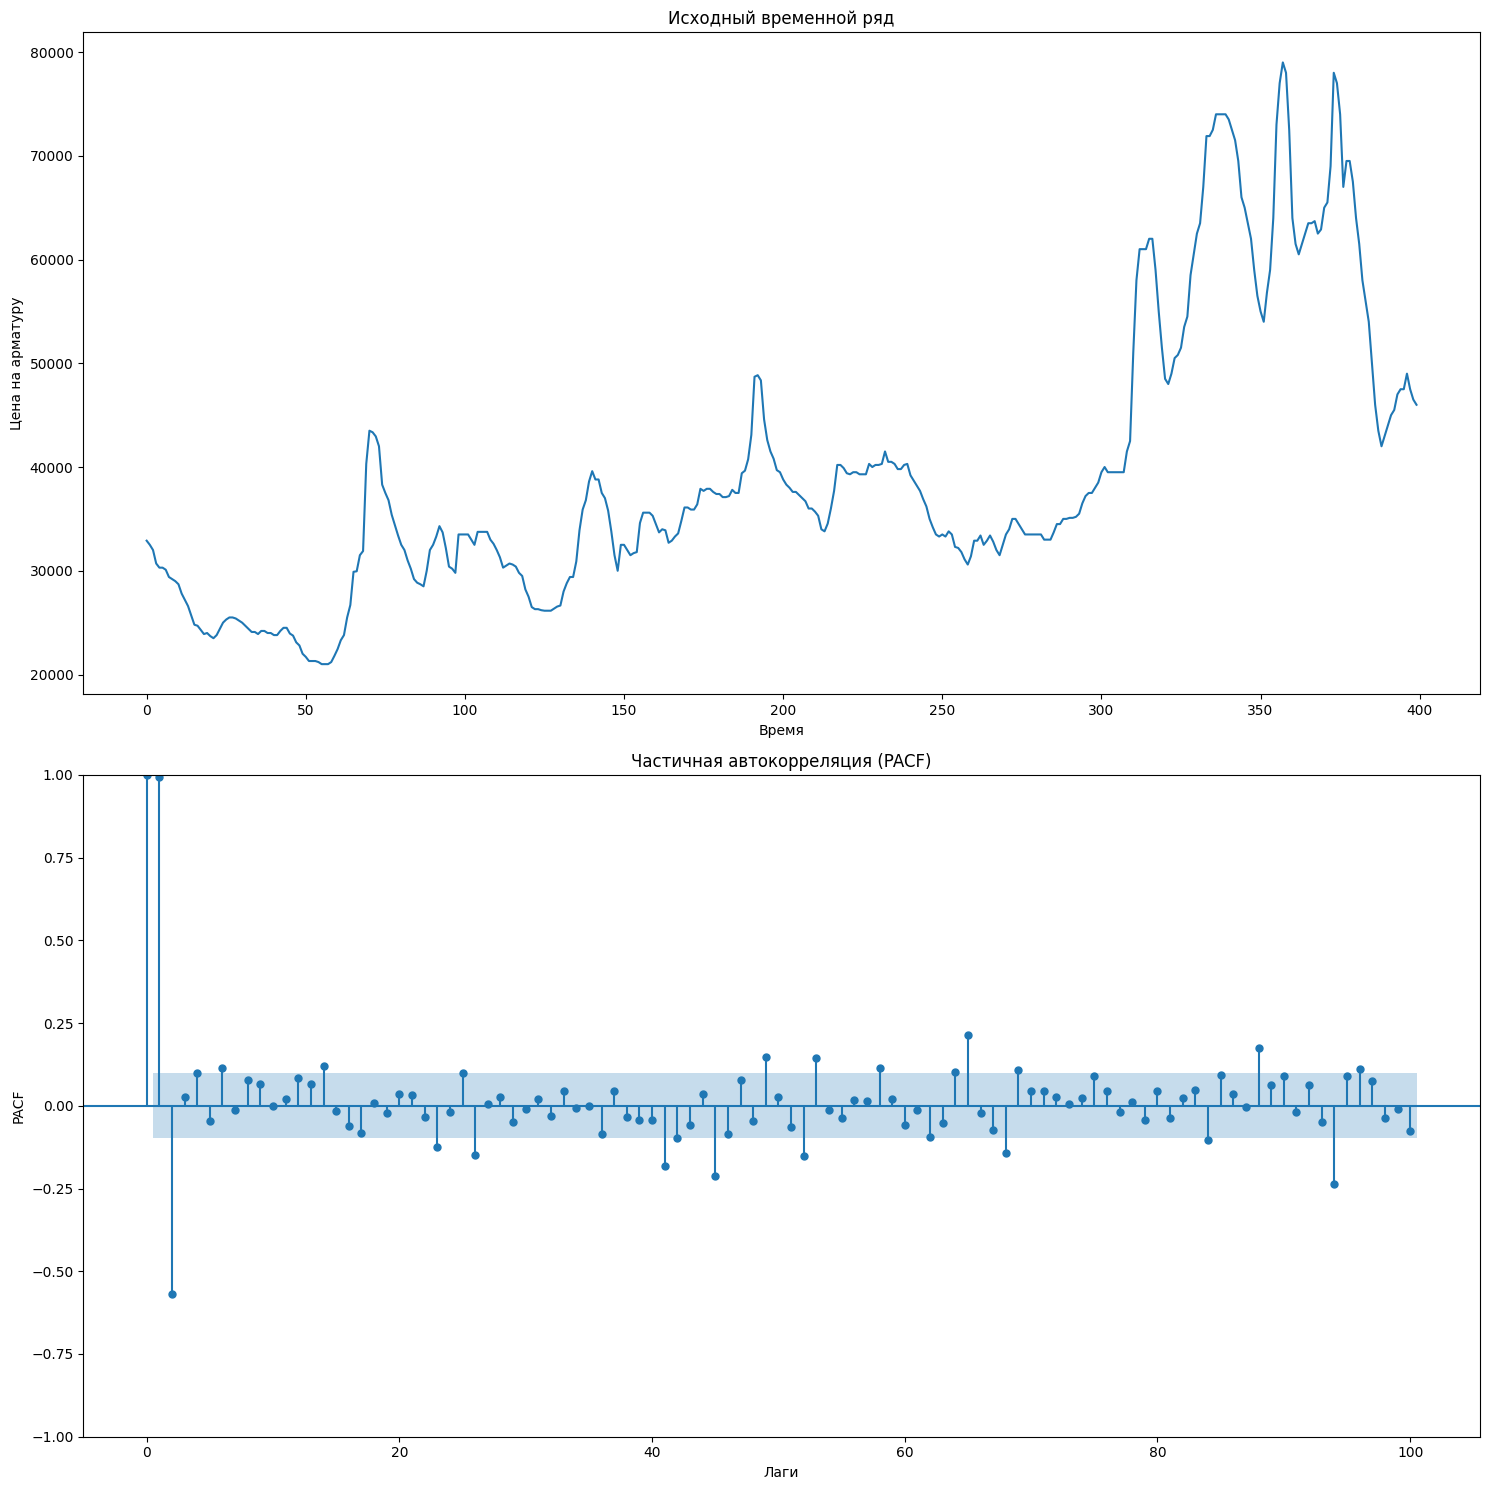

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# Создаем график с двумя подграфиками
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

# Первый подграфик: исходный временной ряд
df_ts['Цена на арматуру'].plot(ax=ax[0])
ax[0].set_title('Исходный временной ряд')
ax[0].set_xlabel('Время')
ax[0].set_ylabel('Цена на арматуру')

# Второй подграфик: PACF (частичная автокорреляция)
plot_pacf(df_ts['Цена на арматуру'], lags=100, ax=ax[1], method='ols')
ax[1].set_title('Частичная автокорреляция (PACF)')
ax[1].set_xlabel('Лаги')
ax[1].set_ylabel('PACF')

# Отображаем график
plt.tight_layout()
plt.show()

In [16]:
# проверка на стационарность первоначального ряда
# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Цена на арматуру'])

ADF Statistic: -1.9258699893713456
p-value: 0.31999061025699155
Critical Values: {'1%': -3.4470566389664703, '5%': -2.8689037160476016, '10%': -2.570692663557422}
Ряд нестационарен (p-value >= 0.05)


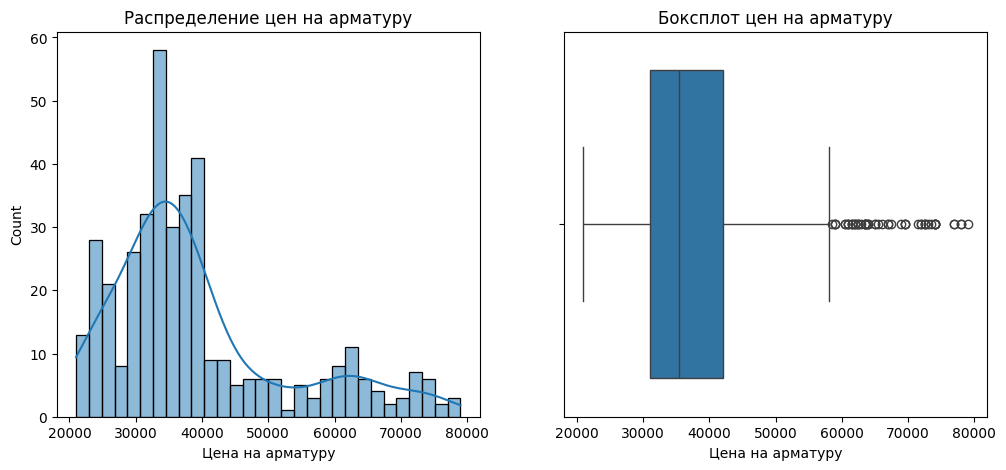

In [17]:
plt.figure(figsize=(12, 5))

# Гистограмма
plt.subplot(1, 2, 1)
sns.histplot(df_ts["Цена на арматуру"], bins=30, kde=True)
plt.title("Распределение цен на арматуру")

# Боксплот
plt.subplot(1, 2, 2)
sns.boxplot(x=df_ts["Цена на арматуру"])
plt.title("Боксплот цен на арматуру")

plt.show()

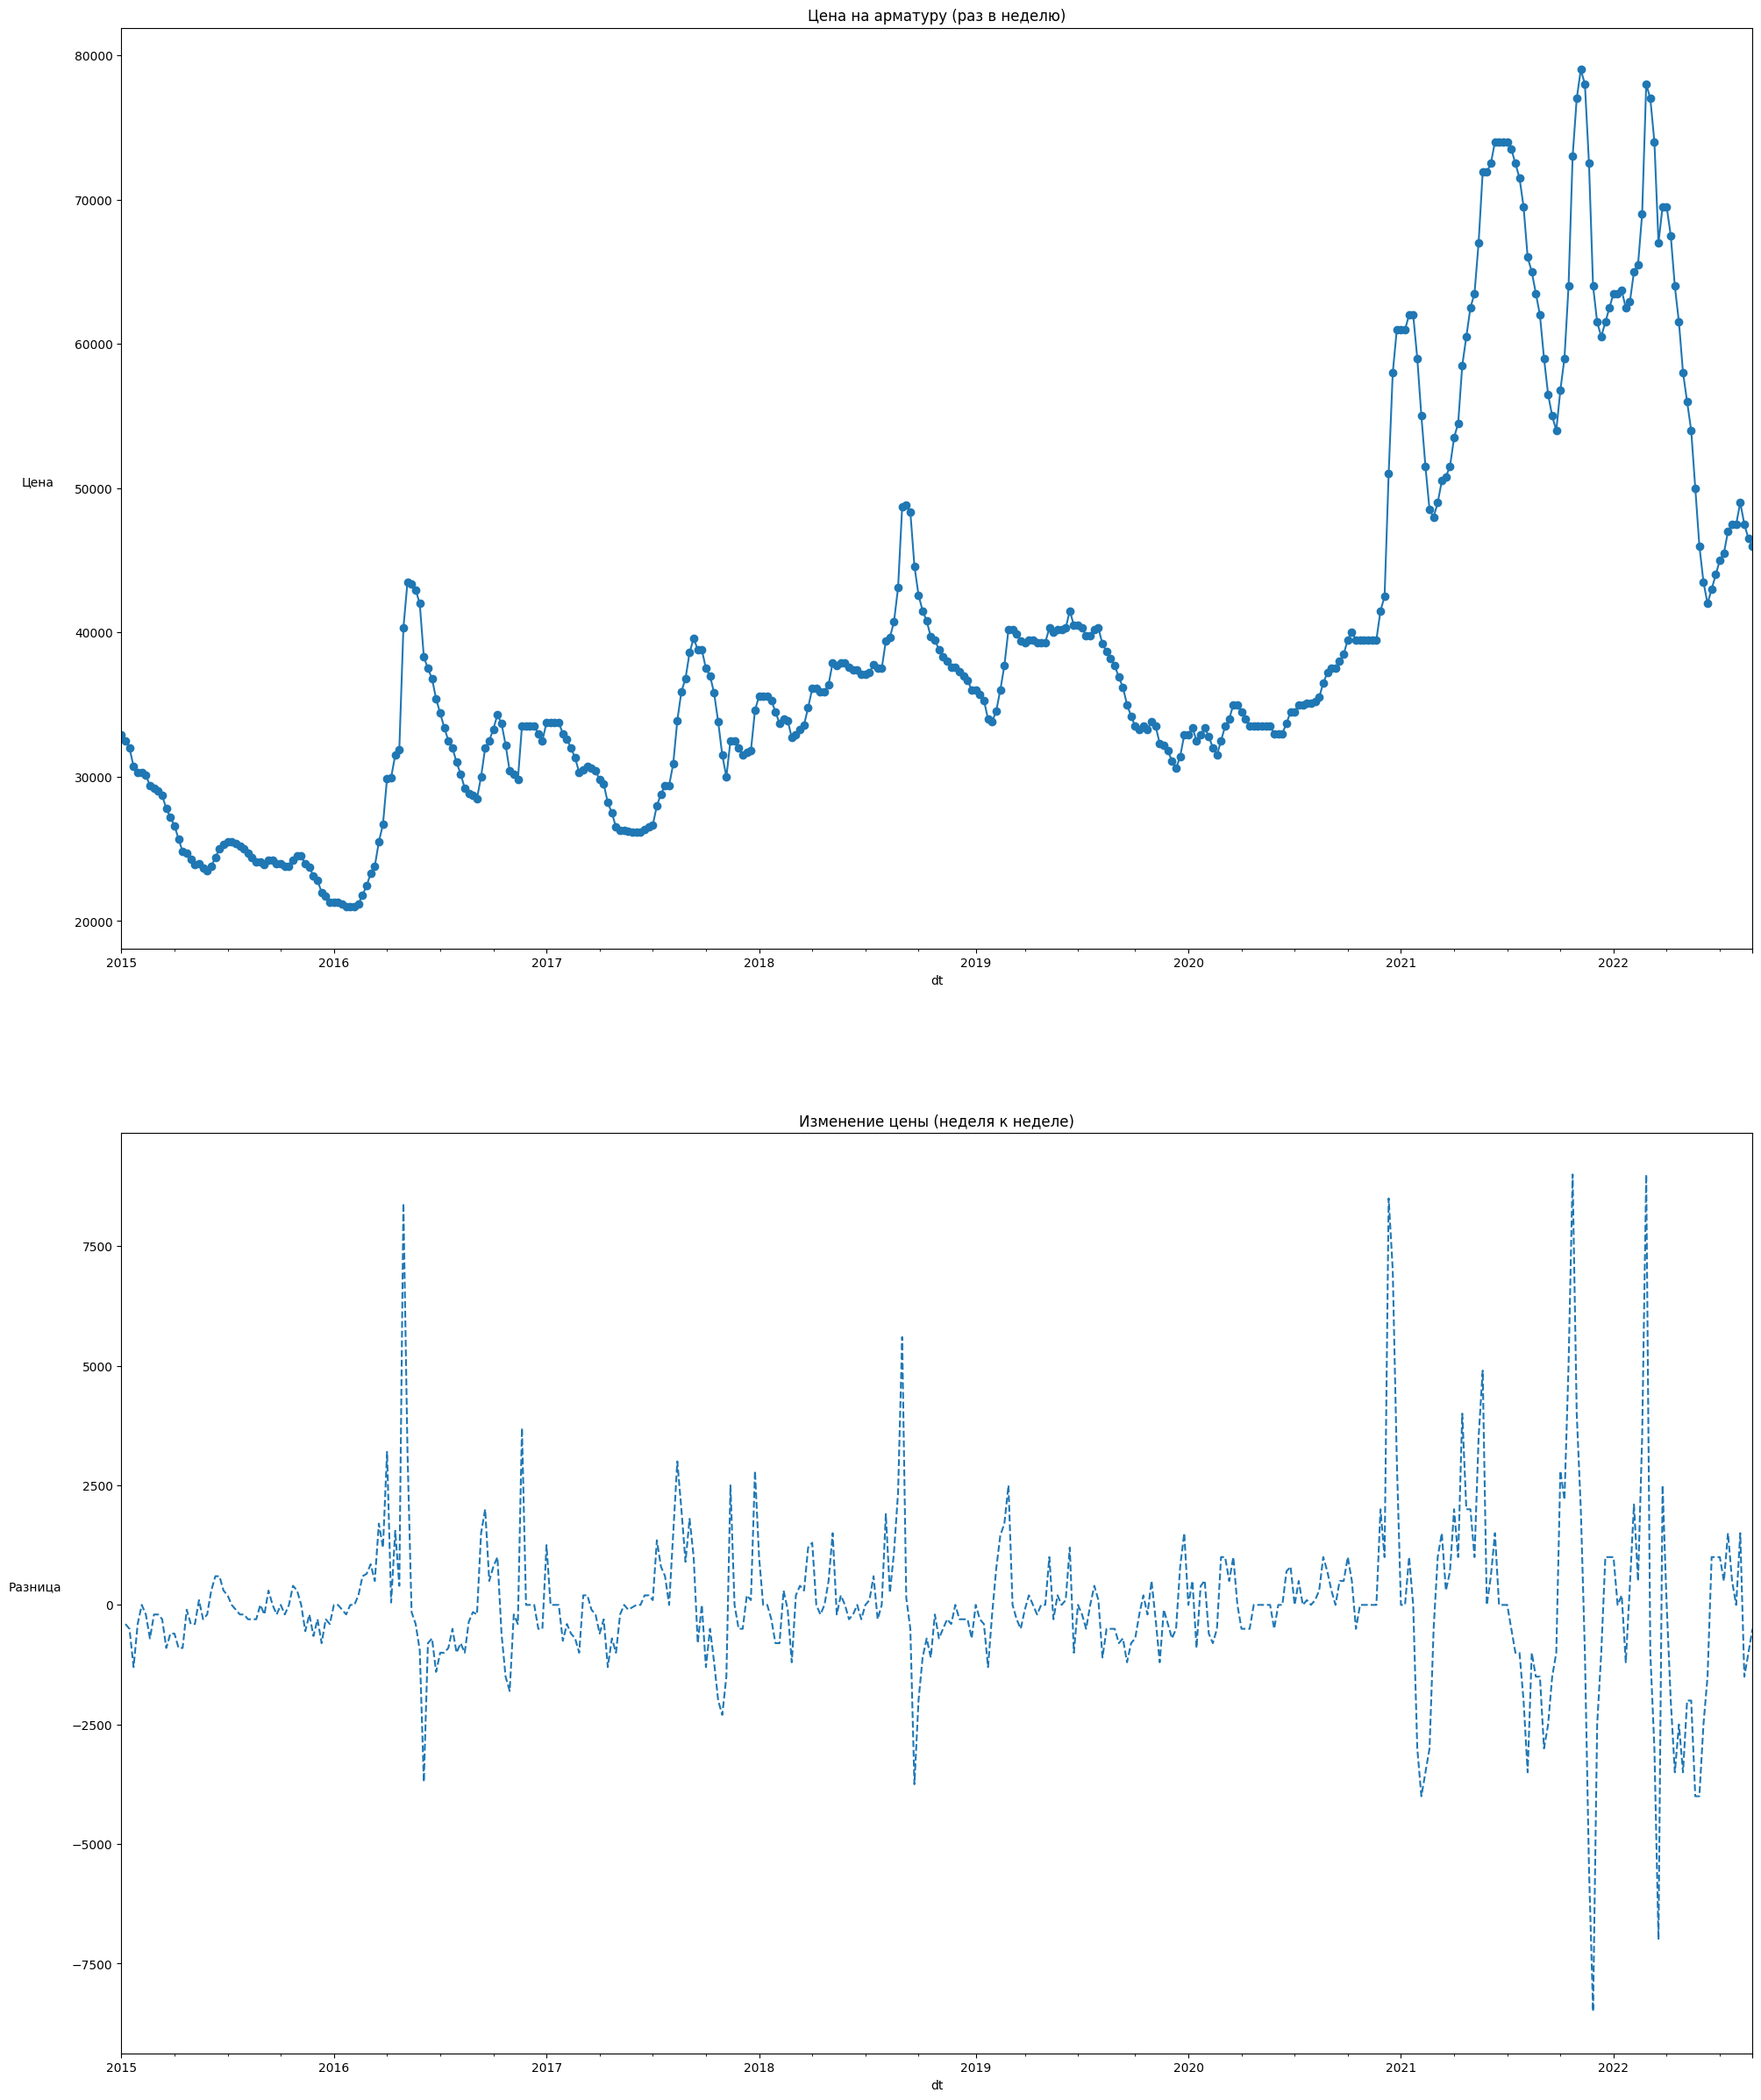

In [18]:
df_ts['Цена_разница_неделя'] = df_ts['Цена на арматуру'].diff(1)  # Разница с прошлой неделей

plt.figure(figsize=(24, 30))

ax1 = plt.subplot(211)
ax1.set_title('Цена на арматуру (раз в неделю)')
ax1.set_ylabel('Цена', rotation=0, labelpad=30)
df_ts.set_index('dt')['Цена на арматуру'].plot(ax=ax1, marker='o')

ax2 = plt.subplot(212)
ax2.set_title('Изменение цены (неделя к неделе)')
ax2.set_ylabel('Разница', rotation=0, labelpad=30)
df_ts.set_index('dt')['Цена_разница_неделя'].plot(ax=ax2, marker='', linestyle='dashed')

plt.show()

In [19]:
df_ts.replace(np.nan, 0, inplace=True)

In [20]:
df_ts.head(10)

,dt,Цена на арматуру,Цена_разница_неделя
0,2015-01-05,32900,0.0
1,2015-01-12,32500,-400.0
2,2015-01-19,32000,-500.0
3,2015-01-26,30700,-1300.0
4,2015-02-02,30300,-400.0
5,2015-02-09,30300,0.0
6,2015-02-16,30100,-200.0
7,2015-02-23,29400,-700.0
8,2015-03-02,29200,-200.0
9,2015-03-09,29000,-200.0


In [21]:
# проверка на стационарность diff ряда
# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Цена_разница_неделя'])

ADF Statistic: -7.711973437154185
p-value: 1.2568518586885597e-11
Critical Values: {'1%': -3.447360865754795, '5%': -2.8690374364690445, '10%': -2.5707639493486636}
Ряд стационарен (p-value < 0.05)


In [22]:
from scipy.signal import medfilt

df_ts["Цена на арматуру (сглаженная)"] = medfilt(df_ts["Цена_разница_неделя"], kernel_size=5)

In [23]:
# проверка на стационарность diff ряда после сглаживания
# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Цена на арматуру (сглаженная)'])

ADF Statistic: -7.237213964014841
p-value: 1.9255395178881053e-10
Critical Values: {'1%': -3.44714244478345, '5%': -2.8689414326247995, '10%': -2.5707127699396084}
Ряд стационарен (p-value < 0.05)


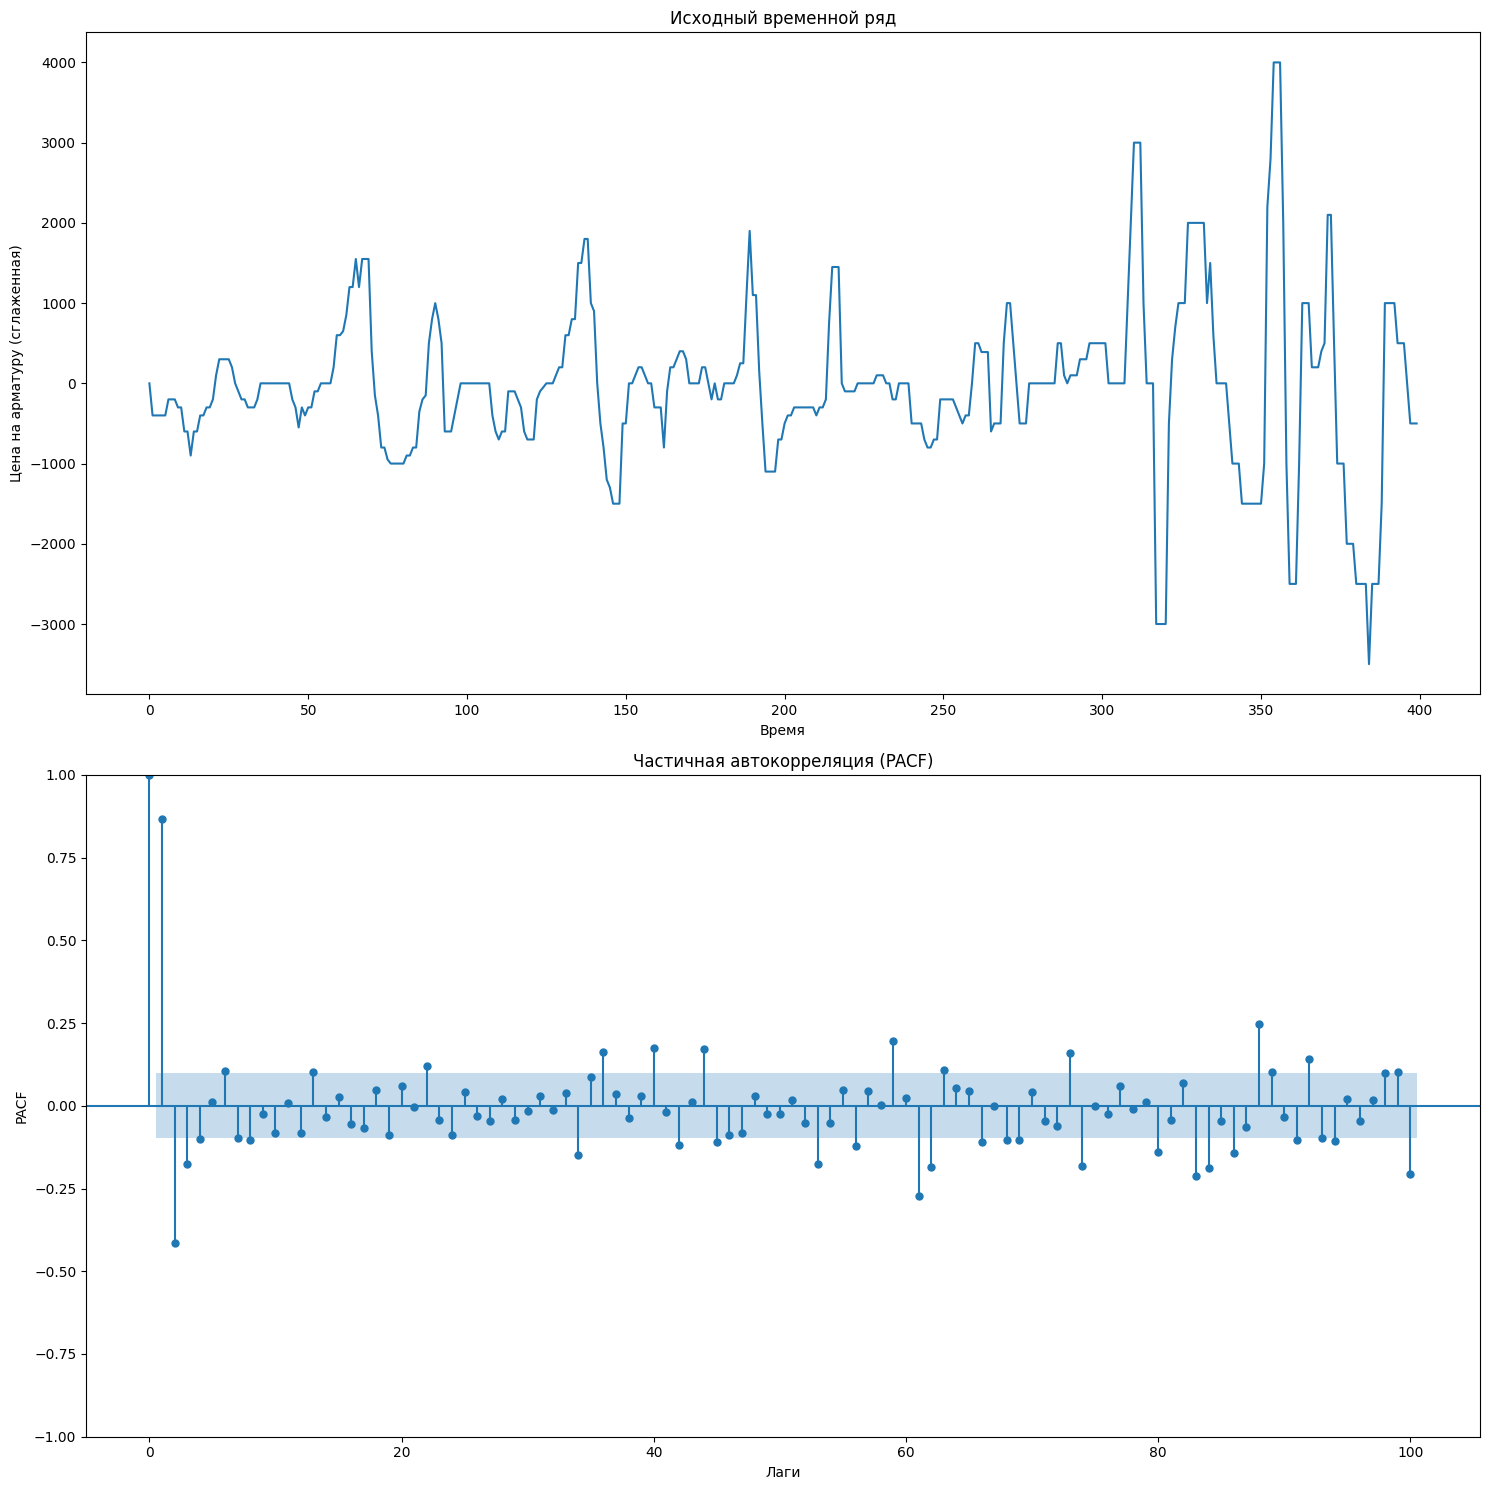

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# Создаем график с двумя подграфиками
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

# Первый подграфик: исходный временной ряд
df_ts['Цена на арматуру (сглаженная)'].plot(ax=ax[0])
ax[0].set_title('Исходный временной ряд')
ax[0].set_xlabel('Время')
ax[0].set_ylabel('Цена на арматуру (сглаженная)')

# Второй подграфик: PACF (частичная автокорреляция)
plot_pacf(df_ts['Цена на арматуру (сглаженная)'], lags=100, ax=ax[1], method='ols')
ax[1].set_title('Частичная автокорреляция (PACF)')
ax[1].set_xlabel('Лаги')
ax[1].set_ylabel('PACF')

# Отображаем график
plt.tight_layout()
plt.show()

# Модели

In [25]:
# 1. Нормализация данных для LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
df_ts["Цена на арматуру (сглаженная)"] = scaler.fit_transform(df_ts[["Цена на арматуру (сглаженная)"]])

# 2. Разделение данных
train_size = int(len(df_ts) * 0.8)
train, test = df_ts.iloc[:train_size].copy(), df_ts.iloc[train_size:].copy()

In [26]:
def create_sequences(df_ts, target_column, seq_length, reshape_for_lstm=False):
    """
    Создает последовательности для временного ряда.

    :param df_ts: DataFrame с временным рядом.
    :param target_column: Название столбца с целевой переменной.
    :param seq_length: Длина окна (количество предыдущих точек для предсказания).
    :param reshape_for_lstm: Флаг, указывающий, нужно ли менять форму для LSTM.
    :return: Кортеж (X, y) с подготовленными выборками.
    """
    if target_column not in df_ts.columns:
        raise KeyError(f"Столбец '{target_column}' не найден в DataFrame!")

    X, y = [], []
    data = df_ts[target_column].values  # Берём нужный столбец как массив

    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # Формируем последовательность длины seq_length
        y.append(data[i + seq_length])  # Следующее значение как целевая переменная

    X, y = np.array(X), np.array(y)

    if reshape_for_lstm:
        X = X.reshape((X.shape[0], X.shape[1], 1))  # Преобразуем для LSTM (samples, timesteps, features)

    return X, y

# Пример использования
seq_length = 20
target_column = "Цена на арматуру (сглаженная)"

X_train, y_train = create_sequences(df_ts, target_column, seq_length, reshape_for_lstm=True)  # Для LSTM
X_test, y_test = create_sequences(df_ts, target_column, seq_length, reshape_for_lstm=True)  # Для LSTM
X_train_lr, y_train_lr = create_sequences(df_ts, target_column, seq_length, reshape_for_lstm=False)  # Для линейной регрессии
X_test_lr, y_test_lr = create_sequences(df_ts, target_column, seq_length, reshape_for_lstm=False)  # Для линейной регрессии

### Линейная регрессия

Средняя абсолютная ошибка (MAE): 0.04
Среднеквадратичная ошибка (MSE): 0.00
Корень среднеквадратичной ошибки (RMSE): 0.06
Коэффициент детерминации (R²): 0.8171
Коэффициент (наклон линии): 0.0601
Свободный член (пересечение с осью Y): 0.14


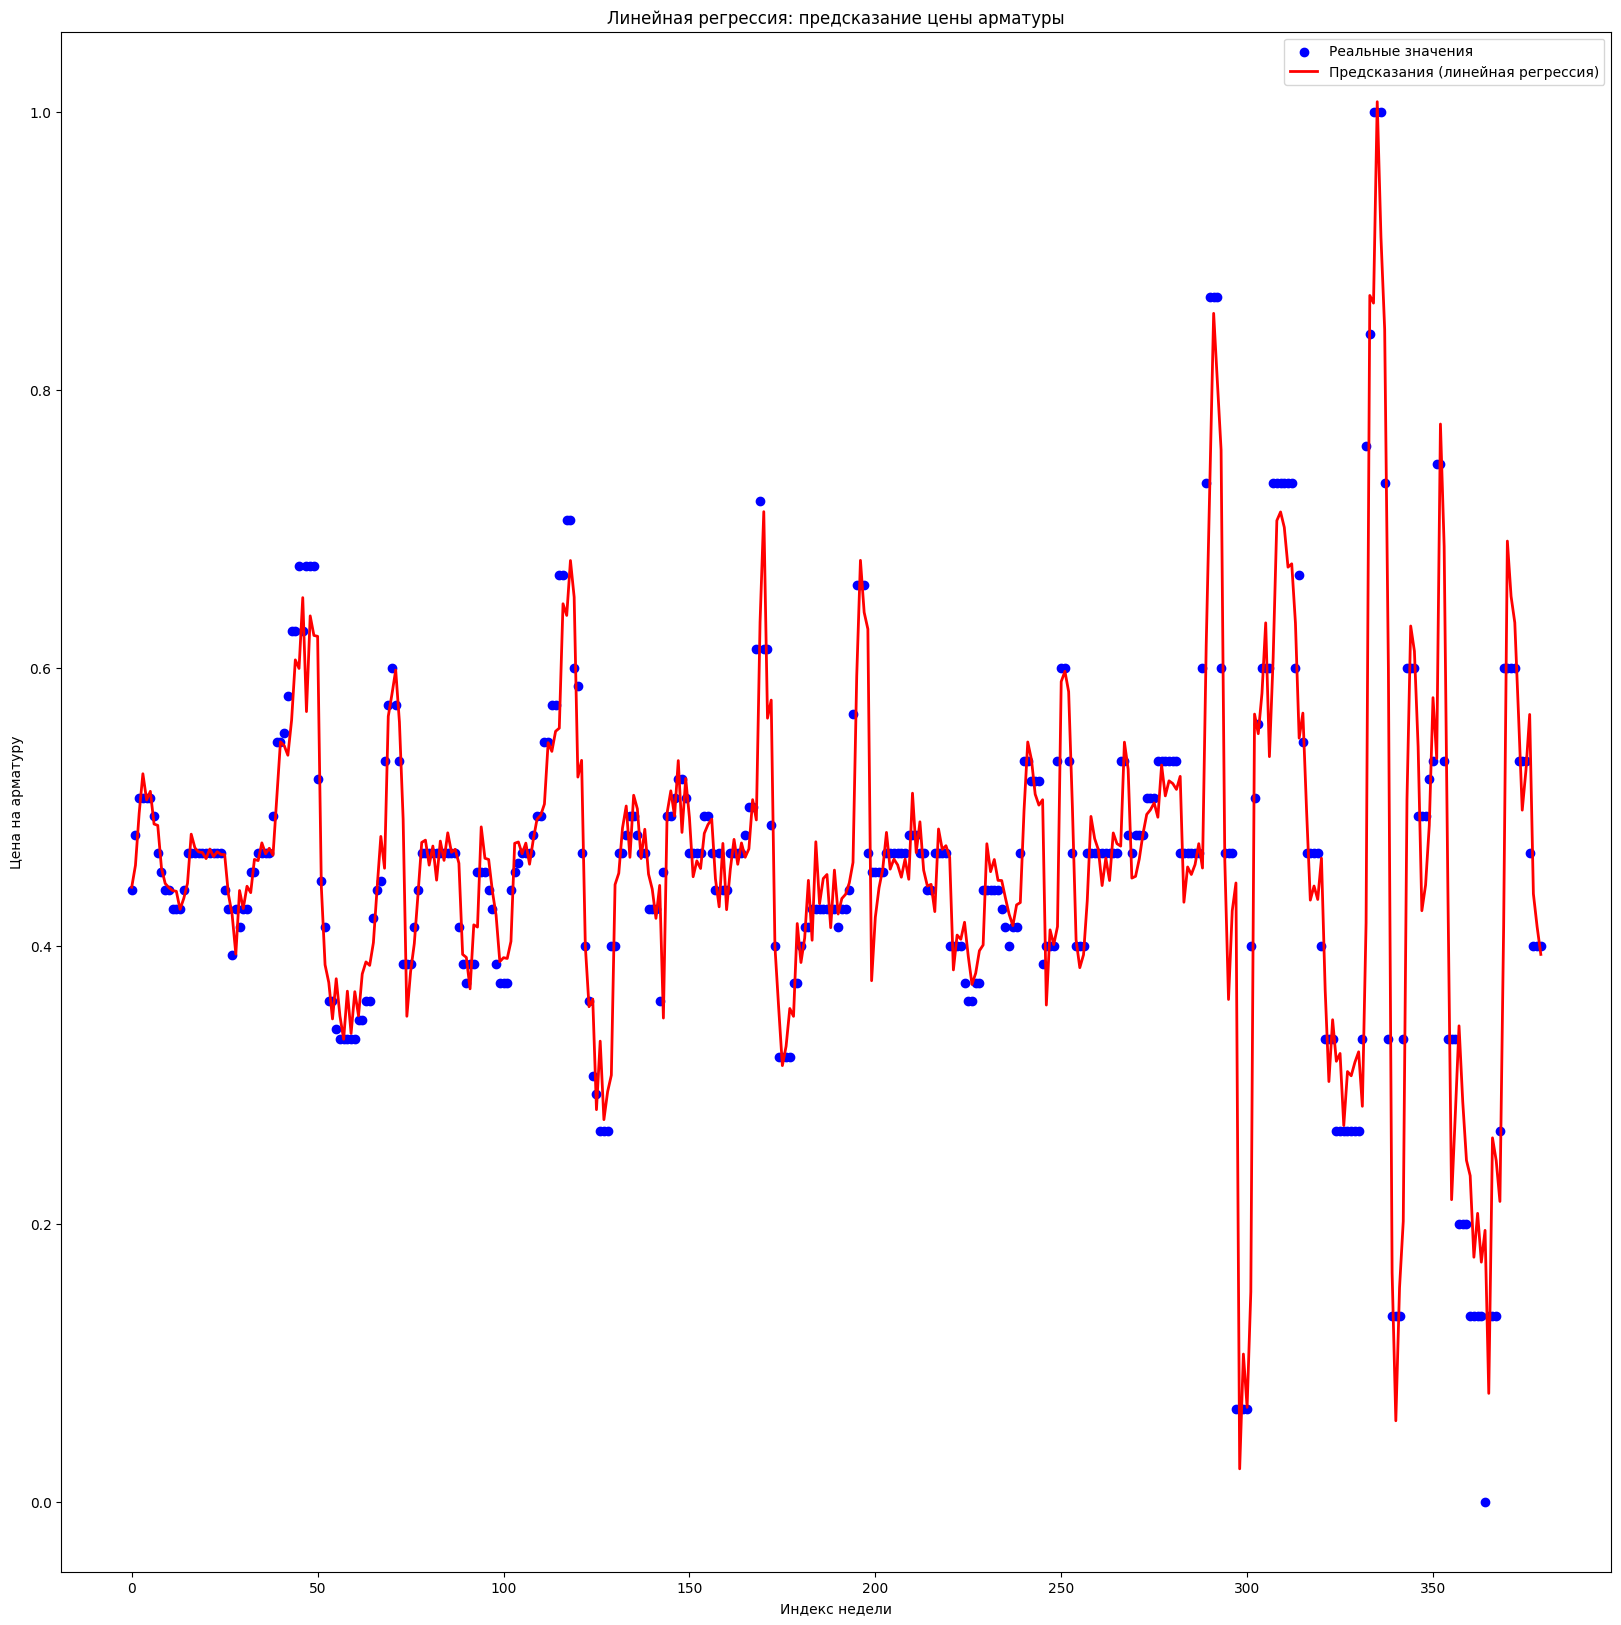

In [27]:


# 5. Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train_lr, y_train_lr)

# 6. Получение предсказаний
y_pred = model.predict(X_test_lr)

# 7. Оценка качества модели
mae = mean_absolute_error(y_test_lr, y_pred)
mse = mean_squared_error(y_test_lr, y_pred)
rmse = np.sqrt(mse)
r2_score = model.score(X_test_lr, y_test_lr)

# Вывод метрик
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")
print(f"Коэффициент детерминации (R²): {r2_score:.4f}")

# 8. Вывод коэффициентов модели
print(f"Коэффициент (наклон линии): {model.coef_[0]:.4f}")
print(f"Свободный член (пересечение с осью Y): {model.intercept_:.2f}")

# 9. Визуализация результатов
plt.figure(figsize=(20, 20))

# Используем range(len(y_test_lr)) вместо X_test_lr для корректного отображения точек
plt.scatter(range(len(y_test_lr)), y_test_lr, color="blue", label="Реальные значения")
plt.plot(range(len(y_pred)), y_pred, color="red", linewidth=2, label="Предсказания (линейная регрессия)")

plt.xlabel("Индекс недели")
plt.ylabel("Цена на арматуру")
plt.title("Линейная регрессия: предсказание цены арматуры")
plt.legend()
plt.show()


### Arima

In [28]:
!pip install --upgrade statsmodels

In [29]:
from statsmodels.tsa.arima_model import ARIMA  # Для старых версий

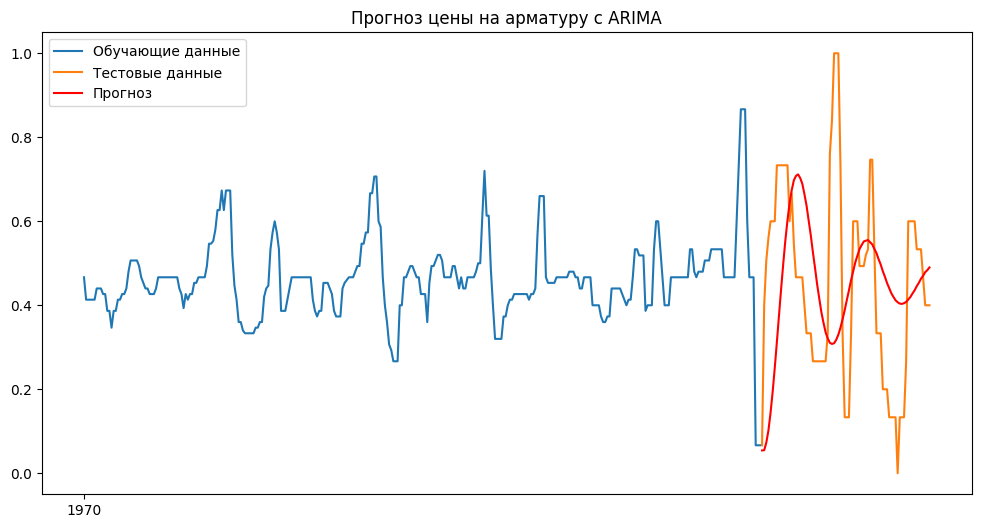

In [37]:


# Создаем и обучаем модель
model = ARIMA(time_series, order=(4, 0, 3))
fitted_model = model.fit()

# Прогноз на тестовый период
forecast_index = test_a.index  # Используем даты тестового набора
forecast = fitted_model.predict(start=forecast_index[0], end=forecast_index[-1])

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train_a.index, train_a['Цена на арматуру (сглаженная)'], label='Обучающие данные')
plt.plot(test_a.index, test_a['Цена на арматуру (сглаженная)'], label='Тестовые данные')
plt.plot(forecast_index, forecast, label='Прогноз', color='red')
plt.legend()
plt.title('Прогноз цены на арматуру с ARIMA')
plt.show()

In [30]:
# Разделение данных (время должно быть индексом)
df_ts.index = pd.to_datetime(df_ts.index)  # Убедимся, что индекс – даты
train_size = int(len(df_ts) * 0.8)
train_a, test_a = df_ts.iloc[:train_size].copy(), df_ts.iloc[train_size:].copy()

In [31]:
# Проверяем, есть ли NaN значения в тренировочных данных
print(f"Количество NaN в тренировочных данных: {df_ts.isna().sum()}")

# Если NaN значения есть, удаляем их
train_clean = df_ts.dropna()

# Проверяем снова, что NaN значения удалены
print(f"Количество NaN после удаления: {train_clean.isna().sum()}")
train_clean.head(10)

Количество NaN в тренировочных данных: dt                               0
Цена на арматуру                 0
Цена_разница_неделя              0
Цена на арматуру (сглаженная)    0
dtype: int64
Количество NaN после удаления: dt                               0
Цена на арматуру                 0
Цена_разница_неделя              0
Цена на арматуру (сглаженная)    0
dtype: int64


,dt,Цена на арматуру,Цена_разница_неделя,Цена на арматуру (сглаженная)
0,2015-01-05,32900,0.0,0.466667
1,2015-01-12,32500,-400.0,0.413333
2,2015-01-19,32000,-500.0,0.413333
3,2015-01-26,30700,-1300.0,0.413333
4,2015-02-02,30300,-400.0,0.413333
5,2015-02-09,30300,0.0,0.413333
6,2015-02-16,30100,-200.0,0.440000
7,2015-02-23,29400,-700.0,0.440000
8,2015-03-02,29200,-200.0,0.440000
9,2015-03-09,29000,-200.0,0.426667


In [38]:
# Выбираем столбец с данными временного ряда
from statsmodels.tsa.arima.model import ARIMA

# Выбираем столбец с данными временного ряда
time_series = df_ts['Цена на арматуру (сглаженная)']

# Создаем модель ARIMA с порядком (4, 0, 3)
model = ARIMA(time_series, order=(4, 0, 3))

# Обучаем модель
fitted_model = model.fit()

# Выводим результаты
print(fitted_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:     Цена на арматуру (сглаженная)   No. Observations:                  400
Model:                            ARIMA(4, 0, 3)   Log Likelihood                 562.828
Date:                           Thu, 20 Mar 2025   AIC                          -1107.655
Time:                                   00:03:05   BIC                          -1071.732
Sample:                               01-01-1970   HQIC                         -1093.429
                                    - 01-01-1970                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4617      0.012     38.852      0.000       0.438       0.485
ar.L1          0.4462      0.419      1.065

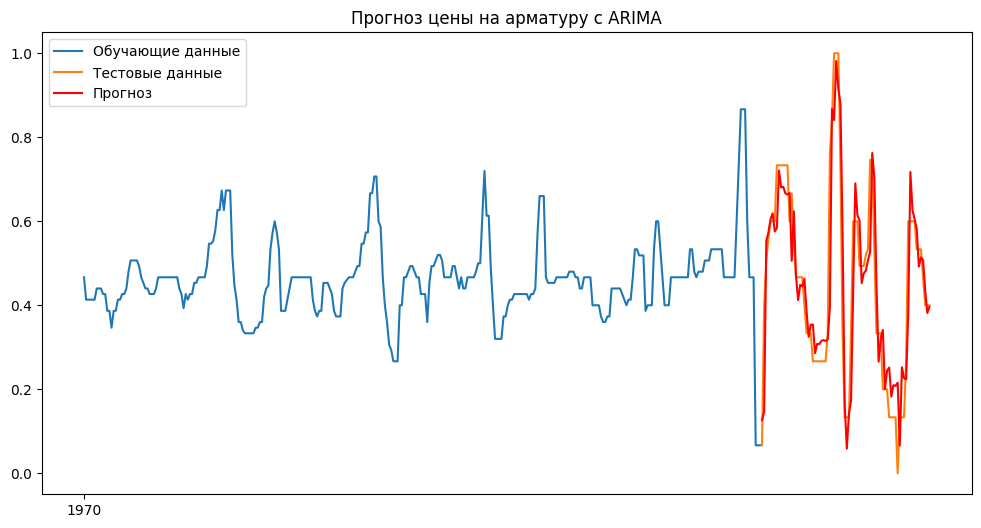

In [40]:
# Прогноз на тестовый период
forecast_index = test_a.index  # Используем даты тестового набора
forecast = fitted_model.predict(start=forecast_index[0], end=forecast_index[-1])

# Визуализируем результат
# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train_a.index, train_a['Цена на арматуру (сглаженная)'], label='Обучающие данные')
plt.plot(test_a.index, test_a['Цена на арматуру (сглаженная)'], label='Тестовые данные')
plt.plot(forecast_index, forecast, label='Прогноз', color='red')
plt.legend()
plt.title('Прогноз цены на арматуру с ARIMA')
plt.show()


### LSTM

In [34]:
# 5. Создание и обучение LSTM-модели

# Построение модели LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Компиляция модели
model.compile(optimizer="adam", loss="mse")

# Обучение модели
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 0.0778 - val_loss: 0.0198
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0187 - val_loss: 0.0191
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0201 - val_loss: 0.0182
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0164 - val_loss: 0.0178
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.0201 - val_loss: 0.0172
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0161 - val_loss: 0.0162
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0157 - val_loss: 0.0157
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0181 - val_loss: 0.0150
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0167 - val_loss: 0.0129
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0144 - val_loss: 0.0119
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0114 - val_loss: 0.0108
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
MAE: 317.92
RMSE: 479.00
Общая длина df_ts: 400
train_size: 320, seq_length: 20
Длина df_ts после train_size + seq_length: 60
Размер y_test_inv: (380, 1)
Размер y_pred_inv: (380, 1)
Последние 10 дат в df_ts:
390   2022-06-27
391   2022-07-04
392   2022-07-11
393   2022-07-18
394   2022-07-25
395   2022-08-01
396   2022-08-08
397   2022-08-15
398   2022-08-22
399   2022-08-29
Name: dt, dtype: datetime64[ns]
Первые 10 дат тестового набора:
340   2021-07-12
341   2021-07-19
342   2021-07-26
343   2021-08-02
344   2021-08-09
345   2021-08-16
346   2021-08-23
347   2021-08-30
348   2021-09-06
349   2021-09-13
Name: dt, dtype: datetime64[ns]


ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

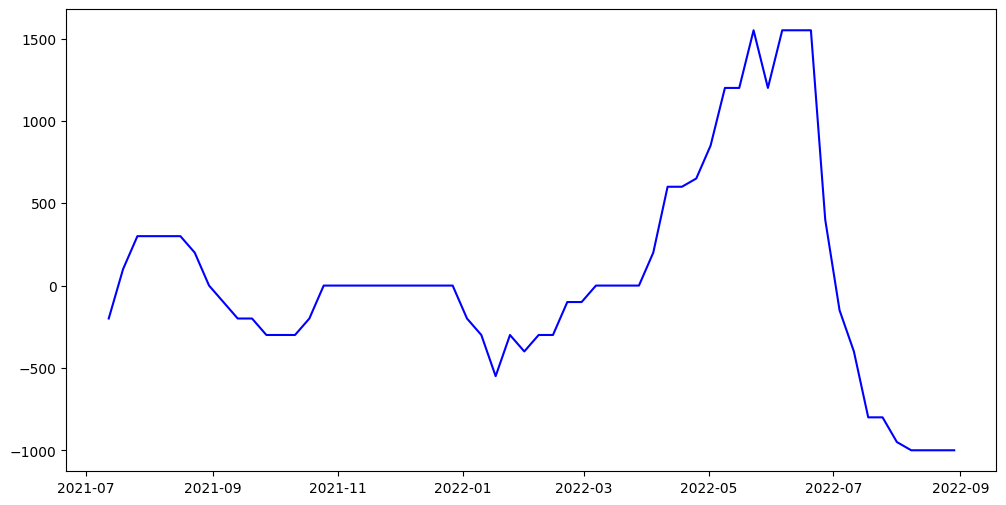

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Предсказания модели
y_pred = model.predict(X_test)

# Обратное масштабирование
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Оценка ошибок
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Проверка размеров данных
print(f"Общая длина df_ts: {len(df_ts)}")
print(f"train_size: {train_size}, seq_length: {seq_length}")
print(f"Длина df_ts после train_size + seq_length: {len(df_ts.iloc[train_size + seq_length:])}")
print(f"Размер y_test_inv: {y_test_inv.shape}")
print(f"Размер y_pred_inv: {y_pred_inv.shape}")

# Проверяем индексы временных меток
print("Последние 10 дат в df_ts:")
print(df_ts["dt"].tail(10))

print("Первые 10 дат тестового набора:")
print(df_ts["dt"].iloc[train_size + seq_length:train_size + seq_length + 10])

# Приведение размеров временных меток и предсказаний к общему минимуму
min_length = min(len(df_ts["dt"].iloc[train_size + seq_length:]), len(y_test_inv))
dates = df_ts["dt"].iloc[train_size + seq_length:train_size + seq_length + min_length]
y_test_inv = y_test_inv[:min_length].flatten()
y_pred_inv = y_pred_inv[:min_length].flatten()

# Разделяем даты и значения для фактических и прогнозных данных
split_index = len(y_test_inv)  # Последний индекс фактических данных
actual_dates = dates[:split_index]
forecast_dates = dates[split_index - 1:]  # Начинаем прогноз с последней фактической точки

actual_prices = y_test_inv[:split_index]
forecast_prices = np.concatenate([[actual_prices[-1]], y_pred_inv[split_index - 1:]])  # Начинаем с последней фактической цены

# Визуализация
plt.figure(figsize=(12, 6))

# Фактические данные (синяя линия)
plt.plot(actual_dates, actual_prices, label="Фактические цены", color="blue")

# Прогнозные данные (оранжевая линия, начиная с последней фактической точки)
plt.plot(forecast_dates, forecast_prices, label="Прогноз LSTM", color="orange", linestyle="dashed")

plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.legend()
plt.grid(True)
plt.show()


### смесь 2 моделй